# Collect house price data

The best way to collect house price data is using [Zillow API](https://www.zillow.com/howto/api/APIOverview.htm).

This notebook is an academic demonstration of how to crawl information from websites. The data used in this demo is a single page manually downloaded from [Trulia](https://www.trulia.com) and then uploaded to a dummy website hosted by AWS S3.

## Import libraries 

In [1]:
import pandas
import configparser
import psycopg2

In [2]:
config = configparser.ConfigParser()
config.read('config.ini')

host = config['myaws']['host']
db = config['myaws']['db']
user = config['myaws']['user']
pwd = config['myaws']['pwd']

In [3]:
conn = psycopg2.connect(host = host,
                       user = user,
                        password = pwd,
                        dbname = db
                       )
cur = conn.cursor()

## Create a table in database

In [4]:
# replace the schema and table name to your schema and table name if necessary
table_sql = """
            CREATE TABLE IF NOT EXISTS house
            (

                price integer,
                bed integer,
                bath integer,
                area integer,
                address VARCHAR(200),
                PRIMARY KEY(address)
            );

            """

In [5]:
# conn.rollback()
# table_sql="drop table if exists house"

In [6]:
cur.execute(table_sql)
conn.commit()

## Define the URL

Fill in the S3 website URL to the `url` variable.

In [7]:
url = 'http://demo-trulia-data-2022-fall.s3-website-us-east-1.amazonaws.com/'

## Collect the research results 

In [8]:
import urllib.request
response = urllib.request.urlopen(url)
html_data= response.read()
# print(html_data.decode('utf-8'))

In [9]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html_data,'html.parser')
# print (soup)

## Insert the records into database

In [10]:
for ul in soup.find_all('ul'):
    for li_class in ul.find_all('li'):
        try:
            for price_div in li_class.find_all('div',{'data-testid':'property-price'}):
                price =int(price_div.text.replace('$','').replace(",",""))
            for bed_div in li_class.find_all('div', {'data-testid':'property-beds'}):
                bed= int(bed_div.text.replace('bd','').replace(",",""))
            for bath_div in li_class.find_all('div',{'data-testid':'property-baths'}):
                bath =int(bath_div.text.replace('ba','').replace(",",""))
            for area_div in li_class.find_all('div',{'data-testid':'property-floorSpace'}):
                area=int(area_div.text.split('sqft')[0].replace(",",""))
            for address_div in li_class.find_all('div',{'data-testid':'property-address'}):
                address =address_div.text
            try:
                sql_insert = """
                            insert into house(price,bed,bath,area,address)
                            values('{}','{}','{}','{}','{}')            
                            """.format(price,bed,bath,area,address)

                cur.execute(sql_insert)
                conn.commit()
            except:
                conn.rollback()
        except:
            pass

## Query the table

In [11]:
df = pandas.read_sql_query('select * from house ', conn)
df[:]

,price,bed,bath,area,address
0,319900,3,2,1740,"501 Hickory Grove Cir, Harrisonburg, VA 22801"
1,379000,3,3,2400,"3204 Marion Sq, Harrisonburg, VA 22801"
2,362500,3,3,1464,"400 Franklin St, Harrisonburg, VA 22801"
3,315000,4,2,2943,"2548 Grace Chapel Rd, Rockingham, VA 22801"
4,325000,4,2,1691,"370 Effinger St, Harrisonburg, VA 22802"
5,145000,4,2,1691,"3010 Woodbury Cir #63, Harrisonburg, VA 22802"
6,249250,3,2,1568,"672 E Market St, Harrisonburg, VA 22801"
7,99900,3,2,1568,"152 Wilton Pl, Rockingham, VA 22801"
8,299900,3,2,1792,"130 N Carlton St, Harrisonburg, VA 22802"
9,649900,3,3,2662,"115 Alnwick Ct, Harrisonburg, VA 22801"


## Basic statistics 

In [12]:
df.describe()

,price,bed,bath,area
count,3.700000e+01,37.000000,37.000000,37.000000
mean,3.705881e+05,3.540541,2.783784,2276.567568
std,2.064287e+05,0.988675,0.786523,1012.027188
min,9.690000e+04,2.000000,1.000000,982.000000
25%,2.625000e+05,3.000000,2.000000,1568.000000
50%,3.249900e+05,3.000000,3.000000,1903.000000
75%,4.199900e+05,4.000000,3.000000,2662.000000
max,1.050000e+06,7.000000,5.000000,4869.000000


## Price distribution

<AxesSubplot:>

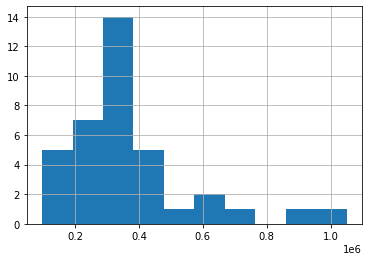

In [13]:
df['price'].hist()

KeyError: 'bed'

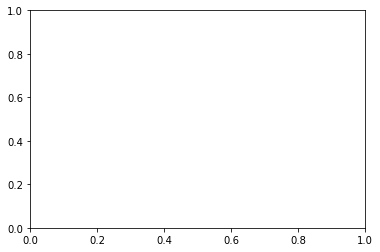

In [34]:
df.plot.scatter(x='bed',y='bath')

#houses with more rooms have more bathrooms

In [40]:
df['price'].mean()

KeyError: 'price'

In [36]:
sql = """
    select avg (price) as avg_price from house
"""
 

In [37]:
df = pandas.read_sql_query(sql,conn)
df[:]

,avg_price
0,370588.108108


In [38]:
sql = """
    select avg(price/area) as unit_price from house
"""

In [39]:
df = pandas.read_sql_query(sql,conn)
df[:]

,unit_price
0,164.378378
